# DoubleDQN

Implementation of DoubleDQN, RL algorithm introduced in "Deep Reinforcement Learning with Double Q-learning", https://arxiv.org/abs/1509.06461

In [1]:
import torch
from torch import nn, optim, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

import numpy as np
import random
import math
import time
from collections import deque, namedtuple

import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output

import gymnasium as gym
from gymnasium import Env

### Hyperparameters

In [78]:
env = gym.make('CartPole-v1')

N_OBSERVATIONS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

# Hyperparameters
eps_start = 1.0
eps_end = 0.1
eps_decay = 5_000 # Number of steps it takes for eps to decay
n_episodes = 500
gamma = 0.99
tau = 1e-2
capacity = 10_000
batch_size = 128
learning_rate = 1e-4
max_grad_norm = 0.5
layer_dim = 128

### Model

In [79]:
class DoubleQNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(N_OBSERVATIONS, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, N_ACTIONS)
        )

    def forward(self, x):
        action_logits = self.network(x)
        return action_logits

### Select action

In [80]:
def select_action(model: DoubleQNetwork, env: Env, state: Tensor, steps_done: int) -> int:
	# Eps decays linearly based on steps_done up to eps_end
	eps = max(eps_end, eps_start - steps_done * (eps_start - eps_end) / eps_decay)
	sample = random.random()

	if sample <= eps:
		# Pick action randomly
		action = env.action_space.sample()
	else:
		# Pick action based on model's prediction
		with torch.no_grad():
			action_logits = model(state)
		action = torch.argmax(action_logits).item()
	
	return action

### Test model

In [81]:
def test_model(model):
	# Initialize environment
	env = gym.make('CartPole-v1', render_mode='human')
	state, _ = env.reset()
	state = torch.from_numpy(state)
	terminated, truncated = False, False
    
	while not (terminated or truncated):
		action = select_action(model, env, state, steps_done=eps_decay)
		next_state, _, terminated, truncated, _ = env.step(action)
		state = torch.from_numpy(next_state)

	env.close()

### Soft update

In [82]:
def soft_update(online_network, target_network, tau):
	# Perform soft update in target network
	for target_param, online_param in zip(target_network.parameters(), online_network.parameters()):
		target_param.data.copy_(tau * online_param.data + (1.0 - tau) * target_param.data)

### Replay memory

In [83]:
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'terminated'])

class ReplayMemory():
	def __init__(self, capacity):
		self.memory = deque(maxlen=capacity)

	def push(self, state: Tensor, action: int, reward: float, next_state: Tensor, terminated: bool):
		transition = Transition(state, action, reward, next_state, terminated)
		self.memory.append(transition)

	def __len__(self):
		return len(self.memory)
	
	def get_batch(self, batch_size):
		# Sample transitions
		sample_size = min(batch_size, len(self))
		transitions = random.sample(self.memory, sample_size)

		# Create batches
		state_batch = torch.stack([t.state for t in transitions])
		action_batch = torch.tensor([t.action for t in transitions])
		reward_batch = torch.tensor([t.reward for t in transitions])
		next_state_batch = torch.stack([t.next_state for t in transitions])
		terminated_batch = torch.tensor([t.terminated for t in transitions])

		return state_batch, action_batch, reward_batch, next_state_batch, terminated_batch

### Train loop

In [87]:
def train_loop(online_network, env, loss_fn, optimizer, n_episodes, batch_size, max_grad_norm, capacity, gamma, tau, total_steps_done):
    # List with total episode rewards
	episode_rewards_list = []

	# Initialize number of steps done
	steps_done = total_steps_done
	
	# Create replay memory
	replay_memory = ReplayMemory(capacity)

	# Create online and target network and load model weights
	target_network = DoubleQNetwork()
	target_network.load_state_dict(online_network.state_dict())

	for episode in range(n_episodes):
		# Initialize environment
		state, _ = env.reset()
		state = torch.from_numpy(state)
		terminated, truncated = False, False
		episode_reward = 0.

		while not (terminated or truncated):
			# Select and perform action
			action = select_action(online_network, env, state, steps_done)
			steps_done += 1
			next_state, reward, terminated, truncated, _ = env.step(action)
			next_state = torch.from_numpy(next_state)

			# Update reward
			episode_reward += reward

			# Store transition
			replay_memory.push(state, action, reward, next_state, terminated)

			# Update state
			state = next_state

			# Only optimize if replay memory has enough transitions
			if len(replay_memory) >= batch_size:
				# Sample random batch of transitions
				state_batch, action_batch, reward_batch, next_state_batch, terminated_batch = replay_memory.get_batch(batch_size)

				# Compute target
				with torch.no_grad():
					next_action = torch.argmax(online_network(state_batch), dim=-1)
					next_pred = target_network(next_state_batch)
					next_reward_pred = next_pred[torch.arange(batch_size), next_action]
					target = reward_batch + (~terminated_batch) * gamma * next_reward_pred

				# Compute predictions
				action_logits = online_network(state_batch)
				pred = action_logits[torch.arange(batch_size), action_batch]

				# Optimize
				loss = loss_fn(target, pred)
				loss.backward()
				clip_grad_norm_(online_network.parameters(), max_grad_norm)
				optimizer.step()
				optimizer.zero_grad()

				# Update target network
				soft_update(online_network, target_network, tau)
		
		# Print and store episode reward
		print(f"episode {episode}, steps done: {steps_done}, reward: {episode_reward}")
		episode_rewards_list.append(episode_reward)

		# Stop if model achieved 500 reward in last 5 episodes
		if episode >= 5:
			stop_training = True
			for i in range(1, 6):
				if episode_rewards_list[-i] < 200:
					stop_training = False
			if stop_training:
				break
	
	return episode_rewards_list


### Train

In [88]:
model = DoubleQNetwork()
loss_fn = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
rewards = train_loop(model, env, loss_fn, optimizer, n_episodes, batch_size, max_grad_norm, capacity, gamma, tau, 0)

episode 0, steps done: 16, reward: 16.0
episode 1, steps done: 32, reward: 16.0
episode 2, steps done: 59, reward: 27.0
episode 3, steps done: 73, reward: 14.0
episode 4, steps done: 93, reward: 20.0
episode 5, steps done: 119, reward: 26.0
episode 6, steps done: 163, reward: 44.0
episode 7, steps done: 174, reward: 11.0
episode 8, steps done: 193, reward: 19.0
episode 9, steps done: 209, reward: 16.0
episode 10, steps done: 224, reward: 15.0
episode 11, steps done: 249, reward: 25.0
episode 12, steps done: 270, reward: 21.0
episode 13, steps done: 285, reward: 15.0
episode 14, steps done: 297, reward: 12.0
episode 15, steps done: 308, reward: 11.0
episode 16, steps done: 365, reward: 57.0
episode 17, steps done: 378, reward: 13.0
episode 18, steps done: 406, reward: 28.0
episode 19, steps done: 438, reward: 32.0
episode 20, steps done: 456, reward: 18.0
episode 21, steps done: 466, reward: 10.0
episode 22, steps done: 495, reward: 29.0
episode 23, steps done: 506, reward: 11.0
episode

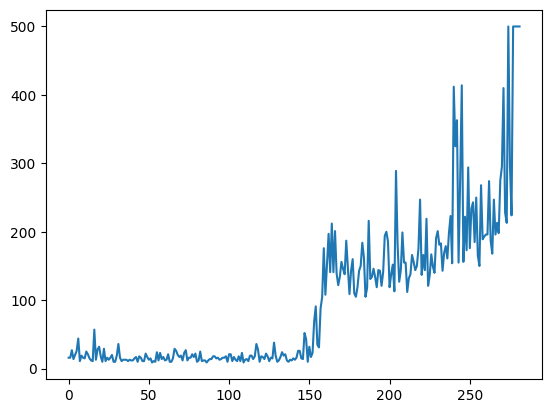

In [90]:
plt.plot(rewards)

In [92]:
test_model(model)